In [1]:
%pylab inline
from octopus.profiles import *
from pygadgetreader import *

font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


# Finding a MW model:

## 1. Choose a Mvir and C.

## 2. Derive the Mh.

\begin{equation}
M_h(r) = M_N(r)
\end{equation}



\begin{equation}
\dfrac{M_H r^2}{a^2(1+r/a)^2} = 4 \pi \rho_s r_s^3 f(x)
\end{equation}

With: $rho_N = \rho_H$ for $r<<a$ it easy to find that:

\begin{equation}
M_H = 2\pi \rho_s a^2 r_s
\end{equation}

In [2]:
# Method from http://adsabs.harvard.edu/abs/2012ApJ...753....8V
def fx(x):
    f = np.log(1.+x) - (x / (1. + x))
    return f

#Computing cvir from c200
def c(cvir, c200):
    q = 2.058
    y = (c200 / cvir) - (fx(c200) / (q * fx(cvir)))**(1./3.)
    return y

def bissection(c200):
    min_cvir = 0.1
    max_cvir = 2*c200
    c_init = 0.5 * (min_cvir + max_cvir)
    y = c(c_init, c200)
    while abs(y) > 0.0002:
        #print c_init
        if y<0:
            max_cvir = c_init
        if y>0:
            min_cvir = c_init
        c_init = 0.5*(min_cvir + max_cvir)
        y = c(c_init, c200)
    return c_init

# Compouting a/rs using cvir
def ars(c):
    x = 1 / ((2.0*fx(c))**(-0.5) - (1.0/c)) # Van Der Marel exact solution#
    x2 = np.sqrt(2.0 * (log(1 + c) - c/(1+c))) # springel approx equation
    return x, x2

# Computing mvir from m200

def mh_mvir(ar, c):
    """
    m200 mvir conversion
    
    """
    x = ar**2.0 / (2.0*fx(c)) 
    return x

def m200mvirNFW(Mvir, cvir, c200):
    M200 = Mvir * fx(c200) / fx(cvir)
    return M200
    
    

In [17]:
# rvir and Mvir, fix r_s, then a can be derived and Mh

def Mh_total(CC, Mvir):
    Mvir = 1.2E12
    CC = 15.
    ars_1, ars_2 = ars(CC)
    #print(ars_1, ars_2)
    Mh = mh_mvir(ars_1, CC)*Mvir
    #print(Mh)
    Rvir = rvir(Mvir,0)
    #print(Rvir)
    r_s = Rvir/CC
    #print(r_s)
    a = r_s*ars_1
    #print(a)
    return(Mh, a, r_s, Rvir)

In [18]:
Mh_total(CC, Mvir)

(1577129925395.6436,
 <Quantity 40.852871619537424 kpc>,
 <Quantity 18.600985112026503 kpc>,
 <Quantity 279.0147766803976 kpc>)

In [11]:
r_pro = linspace(0, 300)
mh_r = mass_hernquist(a.value, r_pro, Mh)
mn_r = mass_NFW(CC, 0, r_pro, 0, Mvir)


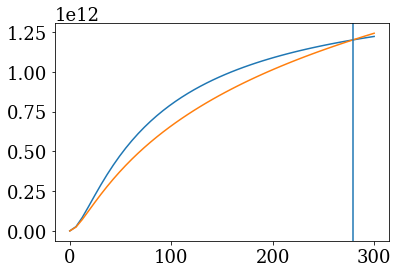

In [14]:
plot(r_pro, mh_r)
plot(r_pro, mn_r)
axvline(Rvir.value)

In [4]:
sim_MW = readsnap('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b/simulations/MW2_40M/MW2_40M_vir_000'
                  , 'pos', 'dm')

Returning DM    Positions


In [5]:
mass_MW = readsnap('/media/ngaravito/4fb4fd3d-1665-4892-a18d-bdbb1185a07b/simulations/MW2_40M/MW2_40M_vir_000'
                  , 'mass', 'dm')

Returning DM    Mass


In [6]:
sum(mass_MW)*1E10

1506642303466.7969

In [7]:
mass_MW[0]*1E10

40176.096263166983

In [8]:
x_sim_mw = sim_MW[:,0]
y_sim_mw = sim_MW[:,1]
z_sim_mw = sim_MW[:,2]

In [9]:
max(x_sim_mw)

79225.391

In [11]:
def mass_profile(x, y, z, n_bins, r):
    mp = 40176.096263166983
    R = np.sqrt(x**2 + y**2 + z**2)
    r = np.linspace(0.0, r, n_bins)
    Mass = np.zeros(n_bins)
    for i in range(len(r)):
        dr = np.where(R<r[i])
        dN = len(x[dr])
        Mass[i] = dN * mp
    return Mass, r

In [32]:
r_max = 279
r_pro = np.logspace(0, log10(r_max))

M, R = mass_profile(x_sim_mw, y_sim_mw, z_sim_mw, 20, r_max)

In [33]:
rvir(1.1999952910892628E12, 0)

<Quantity 279.01441172000966 kpc>

In [34]:
M_NFW = mass_NFW(15, 0 , r_pro, 0, 1.19E12)
M_Hern = mass_hernquist(39.9, r_pro, 1506642303466.7969)

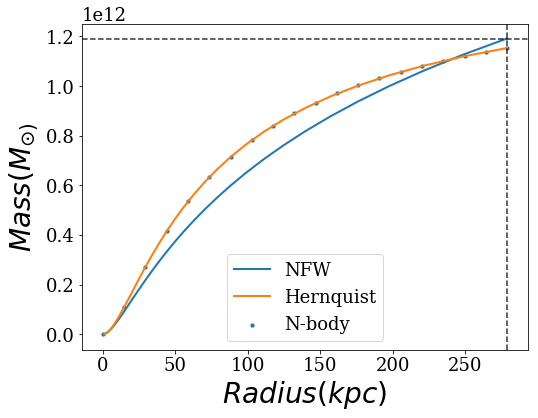

In [37]:
figure(figsize=(8, 6))
plot(r_pro, M_NFW, lw=2, label='NFW')
plot(r_pro, M_Hern, lw=2, label='Hernquist')
scatter(R, M, lw=2, label='N-body', s=5)

axvline(278.832, lw=2, ls='--', c='k', alpha=0.6)
axhline(1.19E12, lw=2, ls='--', c='k', alpha=0.6)
xlabel('$Radius(kpc)$', fontsize=28)
ylabel('$Mass(M_{\odot)}$', fontsize=28)
legend(loc='best')

## note: I think that the miss match is that GalIC have particles way outside Rvir. 